# Testing Sinkhorn implementation

In [23]:
import numpy as np
import torch
from torch.nn import MSELoss
from geomloss import SamplesLoss
from matplotlib import pyplot as plt
%matplotlib inline


def mse_loss(x_pred, x_true):
    return MSELoss()(x_pred, x_true)


def make_sinkhorn_divergence(blur=0.05, scaling=0.5, p=2, backend="auto"):
    """ See http://www.kernel-operations.io/geomloss/api/pytorch-api.html """
    sinkhorn = SamplesLoss("sinkhorn", p=p, blur=blur, scaling=scaling, backend=backend)

    def sinkhorn_divergence(x_gen, x_true):
        return sinkhorn(x_gen, x_true)

    return sinkhorn_divergence


sinkhorn_divergence = make_sinkhorn_divergence()

## Test

In [30]:
a = torch.tensor([[0.,0.], [5., 2.]])
b = torch.tensor([[5.,2.], [0., 0.]])

sinkhorn_divergence(a, b), mse_loss(a, b)

(tensor(0.), tensor(14.5000))

## Systematic comparison

In [41]:
def experiment(batchsize=1, dim=10, batches=200):
    a_list = [torch.rand((batchsize, dim)) for _ in range(batches)]
    b_list = [a + torch.rand((batchsize, dim)) for a in a_list]
    
    mses = [mse_loss(a, b).numpy() for a, b in zip(a_list, b_list)]
    sinkhorns = [sinkhorn_divergence(a, b).numpy() for a, b in zip(a_list, b_list)]
    
    return mses, sinkhorns

In [42]:
batchsizes = [1, 100, 100, 100]
dims = [20, 1, 3, 20]
mses = []
sinkhorns = []

for batchsize, dim in zip(batchsizes, dims):
    mses_, sinkhorns_ = experiment(batchsize=batchsize, dim=dim)
    mses.append(mses_)
    sinkhorns.append(sinkhorns_)

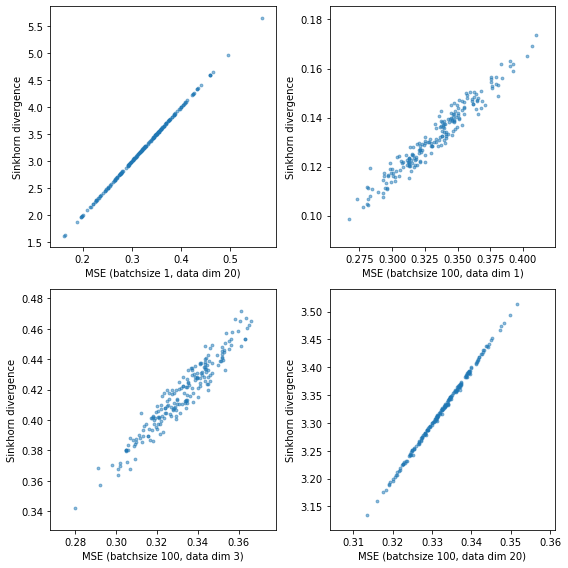

In [43]:
fig = plt.figure(figsize=(8,8))

for panel, (bs, dim, mse, sinkhorn) in enumerate(zip(batchsizes, dims, mses, sinkhorns)):
    ax = plt.subplot(2,2,panel+1)
    plt.scatter(mse, sinkhorn, s=8., alpha=0.5)
    plt.xlabel("MSE (batchsize {}, data dim {})".format(bs, dim))
    plt.ylabel("Sinkhorn divergence")

plt.tight_layout()
plt.show()